In [1]:
import numpy as np
import random
n_qubits=6
import matplotlib.pyplot as plt

In [2]:
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
CNOT_ideal=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
I=np.eye(2)
def Fidelity(a,b):
    return np.real(np.trace(a@b)+2*np.sqrt(np.linalg.det(a)*np.linalg.det(b)))
def Rz(theta):
    return np.array([[np.exp(-1j*theta/2),0],[0,np.exp(1j*theta/2)]])
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])

In [3]:
#generating random hamiltonian and initial state
def phi(): #random phi and theta
    return random.random()*2*0.1
def theta():
    return -random.random()*0.1+np.pi
def get_psi(n_qubits):
    psi = np.reshape((2*(np.random.randn(2**n_qubits)-0.5) + 2j*(np.random.rand(2**n_qubits)-0.5)), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    return psi
phi_m=np.array([phi() for i in range(int(n_qubits*(n_qubits-1)/2))])
theta_m=np.array([theta() for i in range(int(n_qubits*(n_qubits-1)/2))])
psi0=get_psi(n_qubits)
rho0=psi0@psi0.T.conjugate()

In [4]:
def Pauli_error(p):
    a=random.random()
    if a<p/3:
        return X
    if a<(2*p)/3:
        return Y
    if a<p:
        return Z
    return np.eye(2)
def n_qubit_Pauli_er(p):
    error=Pauli_error(p)
    for i in range(n_qubits-1):
        error=np.kron(error,Pauli_error(p))
    return error
def j(t):
    return np.array([[np.exp(-1j*t),0,0,0],[0,np.exp(1j*t),0,0],[0,0,np.exp(1j*t),0],[0,0,0,np.exp(-1j*t)]])
def J(t,error_probability=0):
    Layer1=np.array([1])
    for i in range(int(n_qubits/2)):
        Layer1=np.kron(Layer1,j(t))
    Layer2=np.eye(2)
    for i in range(int(n_qubits/2)-1):
        Layer2=np.kron(Layer2,j(t))
    Layer2=np.kron(Layer2,np.eye(2))
    return n_qubit_Pauli_er(error_probability)@Layer2@Layer1
def refocusing(t,layer=0,error_probability=0):
    if layer==0:
        control=np.array([1])
        for i in range(int(n_qubits/2)):
            if i%2==0:
                control=np.kron(control,I)
                control=np.kron(control,I)
            else:
                control=np.kron(control,X)
                control=np.kron(control,X)
        return control@J(t/2,error_probability=error_probability)@control@J(t/2,error_probability=error_probability)
    control=np.eye(2)
    for i in range(int(n_qubits/2)-1):
        if i%2==0:
                control=np.kron(control,X)
                control=np.kron(control,X)
        else:
                control=np.kron(control,I)
                control=np.kron(control,I)
    if (n_qubits%4==0):
        control=np.kron(control,I)
    else:
        control=np.kron(control,X)
    return control@J(t/2,error_probability=error_probability)@control@J(t/2,error_probability=error_probability)
def evolution(psi0,error_probability=0):
    psi=psi0
    for i in range(int(n_qubits/2)):
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,I)
            layer=np.kron(layer,H@Rz(np.pi/2))
        psi=refocusing(np.pi/4,error_probability=error_probability)@layer@psi
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,H@Ry(-phi_m[j]/2)@Rz(-np.pi/2))
            layer=np.kron(layer,Rz(-theta_m[j]/2)@H@Rz(-np.pi/2))
        psi=refocusing(np.pi/4,error_probability=error_probability)@layer@psi
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,Rz((theta_m[j]-np.pi)/2)@Ry(phi_m[j]/2)@H@Rz(-np.pi/2))
            layer=np.kron(layer,H@Rz(-np.pi/2))
        psi=refocusing(np.pi/4,error_probability=error_probability)@layer@psi
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,Rz(-np.pi/2))
            layer=np.kron(layer,Rz(theta_m[j]/2)@H@Rz(-np.pi/2))
        psi=layer@psi
        layer=np.eye(2)
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,I)
            layer=np.kron(layer,H@Rz(np.pi/2))
        layer=np.kron(layer,I)
        psi=refocusing(np.pi/4,layer=1,error_probability=error_probability)@layer@psi
        layer=np.eye(2)
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,H@Ry(-phi_m[j]/2)@Rz(-np.pi/2))
            layer=np.kron(layer,Rz(-theta_m[j]/2)@H@Rz(-np.pi/2))
        layer=np.kron(layer,I)
        psi=refocusing(np.pi/4,layer=1,error_probability=error_probability)@layer@psi
        layer=np.eye(2)
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,Rz((theta_m[j]-np.pi)/2)@Ry(phi_m[j]/2)@H@Rz(-np.pi/2))
            layer=np.kron(layer,H@Rz(-np.pi/2))
        layer=np.kron(layer,I)
        psi=refocusing(np.pi/4,layer=1,error_probability=error_probability)@layer@psi
        layer=np.eye(2)
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,Rz(-np.pi/2))
            layer=np.kron(layer,Rz(theta_m[j]/2)@H@Rz(-np.pi/2))
        layer=np.kron(layer,I)
        psi=layer@psi
    return psi        

In [5]:
psi=evolution(psi0)

In [6]:
def FSG_ideal(phi,theta):
    return np.array([[1,0,0,0],[0,-1j*np.sin(phi/2),np.cos(phi/2),0],[0,np.cos(phi/2),-1j*np.sin(phi/2),0],[0,0,0,np.exp(1j*theta)]])
def evol(error=0):
    psi=psi0
    for i in range(int(n_qubits/2)):
        F_layer=FSG_ideal(phi_m[i*(n_qubits-1)],theta_m[i*(n_qubits-1)])
        for j in range(1,int(n_qubits/2)):
            F_layer=np.kron(F_layer,FSG_ideal(phi_m[i*(n_qubits-1)+j],theta_m[i*(n_qubits-1)+j]))
        psi=F_layer@psi
        F_layer=np.eye(2)
        for j in range(int(n_qubits/2),int(n_qubits-1)):
            F_layer=np.kron(F_layer,FSG_ideal(phi_m[i*(n_qubits-1)+j],theta_m[i*(n_qubits-1)+j]))
        F_layer=np.kron(F_layer,np.eye(2))
        psi=F_layer@psi
    return psi
psi_errorless=evol()
rho_errorless=psi_errorless@(psi_errorless.T.conjugate())

In [7]:
# error=0.001
# N=100
# psi_samples=np.array([evolution(psi0,error) for i in range(N)])
# fidelity_samples=np.array([Fidelity(psi_samples[i]@psi_samples[i].T.conjugate(),psi_errorless@psi_errorless.T.conjugate()) for i in range(N)])
# plt.hist(fidelity_samples,bins=40,range=(0,1.1),histtype='barstacked',weights=np.array([1/N for i in range(N)]))
# plt.xlabel('Fidelity')
# print(sum(fidelity_samples)/N)
# plt.show()

In [8]:
def Pauli_error1(rho0,error_probability=0):
    Pauli_m=np.array([I*np.sqrt(1-error_probability),X*np.sqrt(error_probability/3),Y*np.sqrt(error_probability/3),Z*np.sqrt(error_probability/3)])
    rho=np.zeros((2**n_qubits,2**n_qubits),dtype='complex')
    for i in range(4):
        for j in range(4):
            for m in range(4):
                for n in range(4):
                    for l in range(4):
                        for k in range(4):
                            U=np.kron(Pauli_m[i],np.kron(Pauli_m[j],np.kron(Pauli_m[m],np.kron(Pauli_m[n],np.kron(Pauli_m[l],Pauli_m[k])))))
                            rho+=U@rho0@U
    return rho
def J1(rho,t,error_probability=0):
    Layer1=np.array([1])
    for i in range(int(n_qubits/2)):
        Layer1=np.kron(Layer1,j(t))
    Layer2=np.eye(2)
    for i in range(int(n_qubits/2)-1):
        Layer2=np.kron(Layer2,j(t))
    Layer2=np.kron(Layer2,np.eye(2))
    return Pauli_error1(Layer2@Layer1@rho@Layer1.conjugate().T@Layer2.T.conjugate(),error_probability=error_probability)
def refocusing1(rho,t,layer=0,error_probability=0):
    if layer==0:
        control=np.array([1])
        for i in range(int(n_qubits/2)):
            if i%2==0:
                control=np.kron(control,I)
                control=np.kron(control,I)
            else:
                control=np.kron(control,X)
                control=np.kron(control,X)
        return control@J1(control@J1(rho,t/2,error_probability=error_probability)@control,t/2,error_probability=error_probability)@control
    control=np.eye(2)
    for i in range(int(n_qubits/2)-1):
        if i%2==0:
                control=np.kron(control,X)
                control=np.kron(control,X)
        else:
                control=np.kron(control,I)
                control=np.kron(control,I)
    if (n_qubits%4==0):
        control=np.kron(control,I)
    else:
        control=np.kron(control,X)
    return control@J1(control@J1(rho,t/2,error_probability=error_probability)@control,t/2,error_probability=error_probability)@control
def evolution1(rho0,error_probability=0):
    rho=rho0
    for i in range(int(n_qubits/2)):
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,I)
            layer=np.kron(layer,H@Rz(np.pi/2))
        rho=refocusing1(layer@rho@layer.T.conjugate(),np.pi/4,error_probability=error_probability)
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,H@Ry(-phi_m[j]/2)@Rz(-np.pi/2))
            layer=np.kron(layer,Rz(-theta_m[j]/2)@H@Rz(-np.pi/2))
        rho=refocusing1(layer@rho@layer.T.conjugate(),np.pi/4,error_probability=error_probability)
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,Rz((theta_m[j]-np.pi)/2)@Ry(phi_m[j]/2)@H@Rz(-np.pi/2))
            layer=np.kron(layer,H@Rz(-np.pi/2))
        rho=refocusing1(layer@rho@layer.T.conjugate(),np.pi/4,error_probability=error_probability)
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,Rz(-np.pi/2))
            layer=np.kron(layer,Rz(theta_m[j]/2)@H@Rz(-np.pi/2))
        rho=layer@rho@layer.T.conjugate()
        layer=np.eye(2)
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,I)
            layer=np.kron(layer,H@Rz(np.pi/2))
        layer=np.kron(layer,I)
        rho=refocusing1(layer@rho@layer.T.conjugate(),np.pi/4,layer=1,error_probability=error_probability)
        layer=np.eye(2)
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,H@Ry(-phi_m[j]/2)@Rz(-np.pi/2))
            layer=np.kron(layer,Rz(-theta_m[j]/2)@H@Rz(-np.pi/2))
        layer=np.kron(layer,I)
        rho=refocusing1(layer@rho@layer.T.conjugate(),np.pi/4,layer=1,error_probability=error_probability)
        layer=np.eye(2)
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,Rz((theta_m[j]-np.pi)/2)@Ry(phi_m[j]/2)@H@Rz(-np.pi/2))
            layer=np.kron(layer,H@Rz(-np.pi/2))
        layer=np.kron(layer,I)
        rho=refocusing1(layer@rho@layer.T.conjugate(),np.pi/4,layer=1,error_probability=error_probability)
        layer=np.eye(2)
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,Rz(-np.pi/2))
            layer=np.kron(layer,Rz(theta_m[j]/2)@H@Rz(-np.pi/2))
        layer=np.kron(layer,I)
        rho=layer@rho@layer.conjugate().T
    return rho        

In [9]:
%%time
n_dots=10
x=np.linspace(0,0.0005,n_dots)
y=np.zeros(n_dots)
for i in range(n_dots):
    y[i]=Fidelity(evolution1(rho0,error_probability=x[i]),rho_errorless)

Wall time: 9min


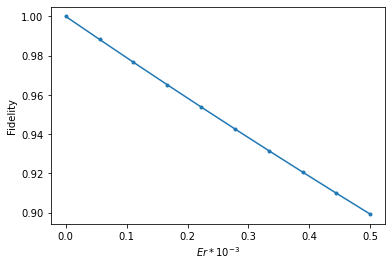

In [10]:
plt.plot(x*1000, y, '.-')
plt.xlabel('$Er*10^{-3}$')
plt.ylabel('Fidelity')
plt.show()

In [11]:
file = open("error_digital_analog_y3.txt", "w")
for i in y:
    file.write(str(i)+"\n")
file.close()